# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql import functions as F
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# create a Spark session, here I allocate extra memory as modelling can be quite resource consuming
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName("Capstone ML") \
    .getOrCreate()

23/01/23 12:12:14 WARN Utils: Your hostname, olekdandrs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.22 instead (on interface en0)
23/01/23 12:12:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/23 12:12:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/23 12:12:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Let's create a spark object
path = "/Users/olekdandryatsenko/personal/Training/PySpark - Capstone Poject/mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
ps.DataFrame(user_log).head(5)

23/01/23 12:12:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
# Let's remove faulty data with empty or 'na' userId and sessionId
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# These libraries will help us to explore data
from pyspark.sql.functions import lit
from pyspark.sql import Window

In [8]:
# Let's identify phases or windows (time units) with sequence of events where users chosen to downgrade 

In [9]:
# first we define a function that marks with 1 all downgrade events (0 otherwise)

flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [10]:
# we create a new column for marked downgrade events

user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [11]:
# we will create a window function in order to identify phases with downgrade events

windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [12]:
# Let's add phase it will help us to identify if user selected downgrade event in a current 

user_log_valid = user_log_valid.withColumn("phase", F.sum("downgraded").over(windowval))

In [13]:
# In order to create set of features let's create a new column
# this column will consist of combined columns - phase, level & page
# we will use this column later on to create a pivot table - transposed table with multiple unique combinations of
# pahse, level and page that would represent a feature

In [14]:
base_df = user_log_valid.select(["userId", "page", "level", "phase"]) \
                                .withColumn("event_count", lit(1))

In [15]:
clean_data = base_df.groupBy(['userId', 'phase','level'])\
                            .pivot('page').agg(F.sum('event_count').alias('event_count'))

In [16]:
# For better visualisation let's see how new table looks like by using pyspark.pandas DataFrames

In [17]:
clean_data = ps.DataFrame(clean_data).fillna(0)

In [18]:
clean_data.head(5)

23/01/23 12:12:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,userId,phase,level,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100,0,paid,2,11,14,0,0,12,1,6,29,11,845,2,0,2,0,0,12,53,0
1,100,0,free,0,6,4,0,0,0,1,3,13,6,232,21,0,0,0,1,1,11,1
2,100,1,paid,10,32,43,0,0,18,1,9,63,18,1605,2,5,9,1,0,14,84,0
3,100005,0,free,0,3,3,1,1,0,0,2,15,3,154,18,0,2,0,0,3,7,4
4,100006,0,free,0,4,1,1,1,0,0,0,2,1,26,3,0,1,0,0,2,2,0


In [19]:
# we will create a window function to go over phase by user_id

windowval = Window.partitionBy("userId").orderBy(F.desc("phase")).rangeBetween(Window.unboundedPreceding, 0)

In [20]:
# we will add a column with the max phase 

base_df = base_df.withColumn("max_phase", F.max("phase").over(windowval))

In [21]:
# Let's check avg metrics by userId, phase and max_phase
explore_df = base_df.groupBy(['userId', 'phase', 'max_phase']) \
                    .pivot('page') \
                    .agg(F.sum('event_count') \
                    .alias('event_count'))

In [22]:
explore_df = explore_df.fillna(0)

In [23]:
# Let's see 
ps.DataFrame(explore_df).head(10)

23/01/23 12:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,userId,phase,max_phase,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100,1,1,10,32,43,0,0,18,1,9,63,18,1605,2,5,9,1,0,14,84,0
1,100,0,1,2,17,18,0,0,12,2,9,42,17,1077,23,0,2,0,1,13,64,1
2,100005,0,0,0,3,3,1,1,0,0,2,15,3,154,18,0,2,0,0,3,7,4
3,100006,0,0,0,4,1,1,1,0,0,0,2,1,26,3,0,1,0,0,2,2,0
4,100007,0,0,0,17,9,1,1,7,0,3,20,5,423,5,1,3,0,0,6,19,0
5,100008,1,1,2,15,30,0,0,10,0,6,20,6,721,11,0,3,1,0,6,36,0
6,100008,0,1,1,2,0,0,0,0,0,0,4,1,51,9,0,0,0,0,0,1,4
7,100010,0,0,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
8,100014,0,0,0,6,7,1,1,3,0,2,7,3,257,2,0,1,0,0,3,17,0
9,100021,0,0,1,7,7,1,1,0,2,0,15,7,230,30,0,0,0,0,5,11,2


In [24]:
# As we can see Cancel events and Cancellation Confirmation are 100% correlated
# therefore later in modelling stage we will use only 'Cancellation Confirmation' as target variable and exlude Cancel
print('correlation', explore_df.stat.corr('Cancellation Confirmation', 'Cancel'))

correlation 1.0


In [25]:
active_users = explore_df.filter(explore_df["Cancellation Confirmation"] == 0).groupBy(['phase']).agg(F.avg(F.col("NextSong")), \
                                                                                           F.avg(F.col("Roll Advert")), \
                                                                                           F.avg(F.col("Add Friend")),
                                                                                           F.avg(F.col("Submit Upgrade")))

active_users = active_users.sort(['phase'])
active_users.show()

+-----+-----------------+------------------+------------------+-------------------+
|phase|    avg(NextSong)|  avg(Roll Advert)|   avg(Add Friend)|avg(Submit Upgrade)|
+-----+-----------------+------------------+------------------+-------------------+
|    0|835.0635838150289|13.936416184971097| 16.07514450867052| 0.5202312138728323|
|    1|800.7551020408164| 9.551020408163266|14.204081632653061| 0.6530612244897959|
|    2|537.0833333333334|14.166666666666666|11.416666666666666| 0.8333333333333334|
|    3|           3124.0|              33.5|              46.5|                1.0|
+-----+-----------------+------------------+------------------+-------------------+



In [26]:
cancelled_users = explore_df.filter(explore_df["Cancellation Confirmation"] == 1).groupBy(['phase']).agg(F.avg(F.col("NextSong")), \
                                                                                           F.avg(F.col("Roll Advert")),\
                                                                                           F.avg(F.col("Add Friend")),
                                                                                           F.avg(F.col("Submit Upgrade")))
cancelled_users = cancelled_users.sort(['phase'])
cancelled_users.show()

+-----+-----------------+------------------+------------------+-------------------+
|phase|    avg(NextSong)|  avg(Roll Advert)|   avg(Add Friend)|avg(Submit Upgrade)|
+-----+-----------------+------------------+------------------+-------------------+
|    0|609.8461538461538|15.711538461538462|10.961538461538462| 0.4807692307692308|
+-----+-----------------+------------------+------------------+-------------------+



In [27]:
# Building a plot - active users
X = ps.DataFrame(active_users).drop('phase').columns 
phase_0 = list(ps.DataFrame(active_users).drop('phase').iloc[0])
phase_1 = list(ps.DataFrame(active_users).drop('phase').iloc[1])
phase_2 = list(ps.DataFrame(active_users).drop('phase').iloc[2])
phase_3 = list(ps.DataFrame(active_users).drop('phase').iloc[3])

23/01/23 12:12:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 1

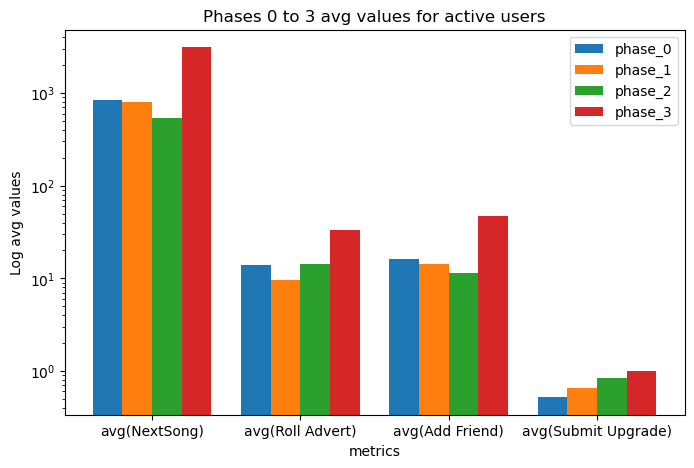

<Figure size 640x480 with 0 Axes>

In [28]:
X_axis = np.arange(len(X))

plt.figure(figsize=(8, 5))
plt.bar(X_axis - 0.3, phase_0, 0.2, label = 'phase_0')
plt.bar(X_axis - 0.1, phase_1, 0.2, label = 'phase_1')
plt.bar(X_axis + 0.1, phase_2, 0.2, label = 'phase_2')
plt.bar(X_axis + 0.3, phase_3, 0.2, label = 'phase_3')
  
plt.xticks(X_axis, X)
plt.xlabel("metrics")
plt.ylabel("Log avg values")
plt.title("Phases 0 to 3 avg values for active users")
plt.legend()
# Setting a logarithmic scale for y-axis
plt.yscale('log')
plt.show()

plt.savefig('active_all_phases.png')

In [29]:
# Building a plot - cancelled_users
X = ps.DataFrame(cancelled_users).drop('phase').columns 
phase_0 = list(ps.DataFrame(cancelled_users).drop('phase').iloc[0])

23/01/23 12:12:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


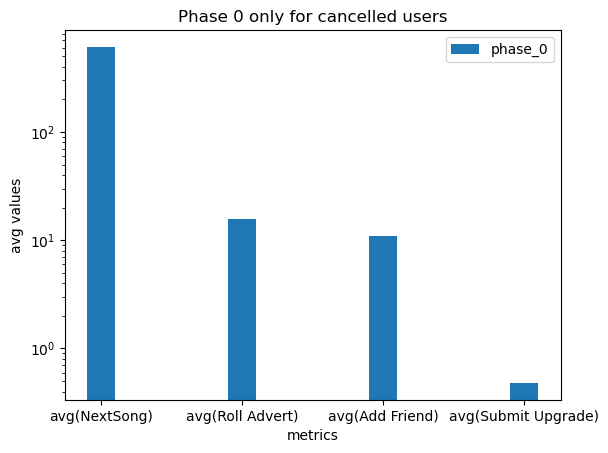

<Figure size 640x480 with 0 Axes>

In [30]:
X_axis = np.arange(len(X))

plt.bar(X_axis, phase_0, 0.2, label = 'phase_0')
  
plt.xticks(X_axis, X)
plt.xlabel("metrics")
plt.ylabel("avg values")
plt.title("Phase 0 only for cancelled users")
plt.legend()
# Setting a logarithmic scale for y-axis
plt.yscale('log')
plt.show()

plt.savefig('cancelled_phase_0.png')

In [31]:
# Simply looking into this two tables we can already see that users who cancelled their account have only  0 phase
# as well as their key engagement metrics have lower averages

In [32]:
# for better visualisation let's plot key events in matplotlib


In [33]:
active_users_max_phase = explore_df.filter(explore_df["Cancellation Confirmation"] == 0).groupBy(['max_phase']).agg(F.avg(F.col("NextSong")), \
                                                                                           F.avg(F.col("Roll Advert")), \
                                                                                           F.avg(F.col("Add Friend")),
                                                                                           F.avg(F.col("Submit Upgrade")))

cancelled_users_max_phase = explore_df.filter(explore_df["Cancellation Confirmation"] == 1).groupBy(['max_phase']).agg(F.avg(F.col("NextSong")), \
                                                                                           F.avg(F.col("Roll Advert")),\
                                                                                           F.avg(F.col("Add Friend")),
                                                                                           F.avg(F.col("Submit Upgrade")))

In [34]:
# cancelled pahse 0
c_p_0 = cancelled_users_max_phase.filter(cancelled_users_max_phase["max_phase"] == 0)\
                      .select(["avg(NextSong)", "avg(Add Friend)", "avg(Roll Advert)", "avg(Submit Upgrade)"])

In [35]:
# active phase 0
a_p_0 = active_users_max_phase.filter(active_users_max_phase["max_phase"] == 0)\
                      .select(["avg(NextSong)", "avg(Add Friend)", "avg(Roll Advert)", "avg(Submit Upgrade)"])

23/01/23 12:12:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 1

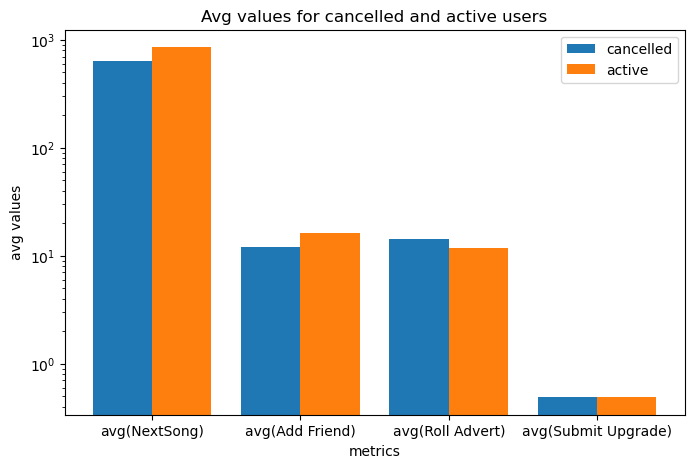

<Figure size 640x480 with 0 Axes>

In [36]:
# Building a plot
X = c_p_0.columns 
cancelled = list(ps.DataFrame(c_p_0).iloc[0])
active = list(ps.DataFrame(a_p_0).iloc[0])
              
X_axis = np.arange(len(X))

plt.figure(figsize=(8, 5))
plt.bar(X_axis - 0.2, cancelled, 0.4, label = 'cancelled')
plt.bar(X_axis + 0.2, active, 0.4, label = 'active')
plt.xticks(X_axis, X)
plt.xlabel("metrics")
plt.ylabel("avg values")
plt.title("Avg values for cancelled and active users")
plt.legend()
# Setting a logarithmic scale for y-axis
plt.yscale('log')
plt.show()

plt.savefig('max_phase_0.png')

In [37]:
# by looking into key engagement metrics averages in phase 0 it's clear that:
# - users remained active are more engaged with the content, they listen to more songs and add more friends
# - also active users roll lest adverts, it can tell us that these users are less irritated by in-app ads.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [38]:
# We will create a set of unique combinations of phase, level and page - these will be the feature set.
transform_df = user_log_valid.select(["userId", "page", "level", "phase"]) \
                                .withColumn('_pivot', F.concat_ws('_', 'phase', 'level')) \
                                .withColumn('_pivot', F.concat_ws('_', '_pivot', 'page')) \
                                .withColumn("event_count", lit(1))

In [39]:
# transposing and aggregating count of each event by user id - we will obtain a final 
# look for our feature set sparse matrix 
features_df = transform_df.groupBy(['userId']) \
                    .pivot('_pivot') \
                    .agg(F.sum('event_count') \
                    .alias('event_count'))
        
features_df = features_df.fillna(0)

In [40]:
ps.DataFrame(features_df).head(5)

23/01/23 12:12:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/01/23 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/23 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/Users/olekdandryatsenko/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  Th

,userId,0_free_About,0_free_Add Friend,0_free_Add to Playlist,0_free_Cancel,0_free_Cancellation Confirmation,0_free_Error,0_free_Help,0_free_Home,0_free_Logout,0_free_NextSong,0_free_Roll Advert,0_free_Save Settings,0_free_Settings,0_free_Submit Upgrade,0_free_Thumbs Down,0_free_Thumbs Up,0_free_Upgrade,0_paid_About,0_paid_Add Friend,0_paid_Add to Playlist,0_paid_Cancel,0_paid_Cancellation Confirmation,0_paid_Downgrade,0_paid_Error,0_paid_Help,0_paid_Home,0_paid_Logout,0_paid_NextSong,0_paid_Roll Advert,0_paid_Save Settings,0_paid_Settings,0_paid_Thumbs Down,0_paid_Thumbs Up,1_free_About,1_free_Add Friend,1_free_Add to Playlist,1_free_Error,1_free_Help,1_free_Home,1_free_Logout,1_free_NextSong,1_free_Roll Advert,1_free_Save Settings,1_free_Settings,1_free_Submit Upgrade,1_free_Thumbs Down,1_free_Thumbs Up,1_free_Upgrade,1_paid_About,1_paid_Add Friend,1_paid_Add to Playlist,1_paid_Downgrade,1_paid_Error,1_paid_Help,1_paid_Home,1_paid_Logout,1_paid_NextSong,1_paid_Roll Advert,1_paid_Save Settings,1_paid_Settings,1_paid_Submit Downgrade,1_paid_Thumbs Down,1_paid_Thumbs Up,2_free_About,2_free_Add Friend,2_free_Add to Playlist,2_free_Help,2_free_Home,2_free_Logout,2_free_NextSong,2_free_Roll Advert,2_free_Save Settings,2_free_Settings,2_free_Submit Upgrade,2_free_Thumbs Down,2_free_Thumbs Up,2_free_Upgrade,2_paid_About,2_paid_Add Friend,2_paid_Add to Playlist,2_paid_Downgrade,2_paid_Error,2_paid_Help,2_paid_Home,2_paid_Logout,2_paid_NextSong,2_paid_Roll Advert,2_paid_Save Settings,2_paid_Settings,2_paid_Submit Downgrade,2_paid_Thumbs Down,2_paid_Thumbs Up,3_free_About,3_free_Add Friend,3_free_Add to Playlist,3_free_Error,3_free_Help,3_free_Home,3_free_Logout,3_free_NextSong,3_free_Roll Advert,3_free_Save Settings,3_free_Settings,3_free_Submit Upgrade,3_free_Thumbs Down,3_free_Thumbs Up,3_free_Upgrade,3_paid_About,3_paid_Add Friend,3_paid_Add to Playlist,3_paid_Downgrade,3_paid_Error,3_paid_Help,3_paid_Home,3_paid_Logout,3_paid_NextSong,3_paid_Roll Advert,3_paid_Save Settings,3_paid_Settings,3_paid_Submit Downgrade,3_paid_Thumbs Down,3_paid_Thumbs Up
0,100,0,6,4,0,0,1,3,13,6,232,21,0,0,1,1,11,1,2,11,14,0,0,12,1,6,29,11,845,2,0,2,12,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,32,43,18,1,9,63,18,1605,2,5,9,1,14,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100005,0,3,3,1,1,0,2,15,3,154,18,0,2,0,3,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100006,0,4,1,1,1,0,0,2,1,26,3,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100008,1,2,0,0,0,0,0,4,1,51,9,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,15,30,10,0,6,20,6,721,11,0,3,1,6,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100010,1,4,7,0,0,0,2,11,5,275,52,0,0,0,5,17,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
print('Total unique users in data set: ' , ps.DataFrame(features_df)['userId'].nunique())

Total unique users in data set:  225


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Step 1. Train Test Split

In [42]:
from pyspark.ml.feature import Normalizer, RegexTokenizer, StandardScaler, VectorAssembler, StringIndexer
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [43]:
# Train / test split - it's worth to use 80/20 % split because the have only 225 unique users.
train, test = features_df.randomSplit([0.7, 0.3], seed = 42)

In [44]:
# We have few cancelled users therefore we need to make sure that they are represented both in test and train sets.

print ('train - cancelled users: ', train.filter(train["0_free_Cancellation Confirmation"] == 1).select(F.sum(train["0_free_Cancellation Confirmation"])).collect()[0][0])
print ('test - cancelled users: ', test.filter(test["0_free_Cancellation Confirmation"] == 1).select(F.sum(test["0_free_Cancellation Confirmation"])).collect()[0][0])

train - cancelled users:  13
test - cancelled users:  8


In [45]:
# Removing target varaible and userId from features - we can use this list of fetures both in train and test sets

features_list = train.columns
features_list.remove('userId')
features_list.remove('0_free_Cancellation Confirmation')
features_list.remove('0_free_Cancel')

### Step 2. Build Pipeline

In [87]:
# We are going to test two models: Decicion Trees and Logistic Regression
# Logistic regression is particularly sensitive to variations in features
# therefore we will normalise and standtartise our features

#assembler = VectorAssembler(inputCols=features_list, outputCol="NumFeatures")
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
#scaler = Normalizer(inputCol="NumFeatures", outputCol="ScaledNumFeatures")
#scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
#scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol = "0_free_Cancellation Confirmation", outputCol = "label")
#indexer2 = StringIndexer(inputCol = "NumFeatures", outputCol = "features")

dtc = DecisionTreeClassifier()
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

#### Decision Tree

In [88]:
dtc_pipeline = Pipeline(stages=[assembler, indexer, dtc])

In [89]:
# dtc_pipeline = Pipeline(stages=[assembler, scaler, scaler2, indexer, dtc])

In [90]:
dtc_model = dtc_pipeline.fit(train)

In [91]:
dtc_pred = dtc_model.transform(test)

In [92]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(dtc_pred)
print("Decision Tree Prediction Accuracy: ", acc)

Decision Tree Prediction Accuracy:  0.8635402156528916


In [93]:
y_pred=dtc_pred.select("prediction").collect()
y_orig=dtc_pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("DT Confusion Matrix:")
print(cm)

DT Confusion Matrix:
[[66  4]
 [ 6  2]]


In [94]:
# Let's extract elements of the confusion matrix
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
precision = TP / ( TP + FP)
recall = TP / (TP + FN)
print('precision: ', precision)
print('recall: ', recall)

precision:  0.3333333333333333
recall:  0.25


#### Logistic Regression

In [95]:
# lr_pipeline = Pipeline(stages=[assembler, scaler, scaler2, indexer, lr])

In [98]:
lr_pipeline = Pipeline(stages=[assembler, indexer, lr])

In [99]:
paramGrid = ParamGridBuilder()\
        .addGrid(lr.regParam, [0.0, 0.1])\
        .build()

In [100]:
crossval = CrossValidator(estimator = lr_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 3)

In [101]:
cv_LR_Model = crossval.fit(train)

23/01/23 12:40:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/01/23 12:40:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [102]:
lr_pred = cv_LR_Model.transform(test)

In [103]:
print("Decision Tree Prediction Accuracy: ", \
      lr_pred.filter(lr_pred.label == lr_pred.prediction).count() / lr_pred.count())

Decision Tree Prediction Accuracy:  0.8974358974358975


In [104]:
y_pred=lr_pred.select("prediction").collect()
y_orig=lr_pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("LR Confusion Matrix:")
print(cm)

LR Confusion Matrix:
[[70  0]
 [ 8  0]]


In [601]:
# Let's extract elements of the confusion matrix
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
precision = TP / ( TP + FP)
recall = TP / (TP + FN)
print('precision: ', precision)
print('recall: ', recall)

precision:  0.2857142857142857
recall:  0.25


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.